In [160]:
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ashleyjeon/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ashleyjeon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [161]:
# imports for getting text from Project Gutenberg
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy

# set up nlp pipline
nlp = spacy.load("en_core_web_sm")
nlp.disable_pipes('ner', 'parser')

['ner', 'parser']

In [162]:
# first, we import the relevant modules from the NLTK library
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [163]:
# next, we initialize VADER so we can use it within our Python script
sid = SentimentIntensityAnalyzer()

# initialize our 'english.pickle' function and give it a short name
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [164]:
response = requests.get('https://www.gutenberg.org/cache/epub/11/pg11.txt')
text = response.text

In [165]:
start = text.find('Alice was beginning to get very tired of sitting by her sister on the')
end = text.find('THE END')
print(start, end)

1490 148811


### Split text into chapters for easier processing

We now have a very long text string containing the entire text of Alice's Adventures in Wonderland. For ease of processing, we will cut the text up into chapters.

In [166]:
alice = text[start:end]
alice_paras = alice.split('\r\nCHAPTER')

### Organize chapters into a Dataframe for processing and storage

As we have seen, a Pandas DataFrame is a handy way to organize data for processing and storage. Here, we will create a DataFrame with columns for author, title, and text where each row represents a paragraph. Of course, in this example, the author and title will be the same for each row.

In [167]:
# creating empty lists for author and title will be handy for building our dataframe
author = []
title = []

In [168]:
# this little for-loop will poplate the lists we just created
for para in alice_paras:
    author.append('Caroll')
    title.append('Alice')

In [169]:
alice_df = pd.DataFrame(list(zip(author, title, alice_paras)), columns=['author', 'title', 'text'])


# for each of the rows, remove extra white space along with the extra '*' sequence of characters
for index, row in alice_df.iterrows():
    text = row['text']
    text = text.replace('\r\n\r\n', '')
    text = text.replace('*      *      *      *      *      *      *    *      *      *      *      *      **      *      *      *      *      *      *', '')
    row['text'] = text

alice_df.head()

,author,title,text
0,Caroll,Alice,Alice was beginning to get very tired of sitti...
1,Caroll,Alice,II.\r\nThe Pool of Tears\r\n“Curiouser and cu...
2,Caroll,Alice,III.\r\nA Caucus-Race and a Long Tale\r\nThey...
3,Caroll,Alice,IV.\r\nThe Rabbit Sends in a Little Bill\r\nI...
4,Caroll,Alice,V.\r\nAdvice from a Caterpillar\r\nThe Caterp...


### Lemmatize text
Now that we have our text divided by paragraphs and stored in a DataFrame, let's apply some nlp to extract the lemmas. We will then place the lemmas into a new column in our DataDrame.

In [170]:
# extract lemmas
def process_text(text):
    """Remove new line characters and lemmatize text. Returns string of lemmas"""
    text = text.replace('\n', ' ')
    doc = nlp(text)
    tokens = [token for token in doc]
    no_stops = [token for token in tokens if not token.is_stop]
    no_punct = [token for token in no_stops if token.is_alpha]
    lemmas = [token.lemma_ for token in no_punct]
    lemmas_lower = [lemma.lower() for lemma in lemmas]
    lemmas_string = ' '.join(lemmas_lower)
    return lemmas_string

In [171]:
alice_df['lemmas'] = alice_df['text'].apply(process_text)

In [172]:
# sanity check
alice_df
alice_df.to_csv("output")

### Sentiment Analysis

We will now use the polarity_scores method on sid and pass in each of the chapters of
Alice's Adventures in Wonderland. This will output a directory with negative, neutral, positive, and compound scores for the input text and we will use a dataframe to store these values.

In [179]:
# Create a dataframe with columns representing the different sentiments
result_df = pd.DataFrame(columns=['Chapter', 'Text', 'Negative', 'Positive', 'Neutral', 'Compound'])
chapter_count = 1

for index, row in alice_df.iterrows():
    text = row['text']

    scores = sid.polarity_scores(text)

    result_df = result_df._append(
        {'Chapter': chapter_count, 'Text': text, 'Negative': scores['neg'], 
        'Positive': scores['pos'], 'Neutral': scores['neu'], 
        'Compound': scores['compound']
        }, ignore_index=True)
    
    chapter_count += 1

result_df.head()
result_df.to_csv('sentiment_results.csv')

### Plots for each of the polarity scores for the sentiment type values.

Negative, neutral, positive sentiment are plotted along with the compound value which is
the overall score that combines these three sentiments into a singular score.  

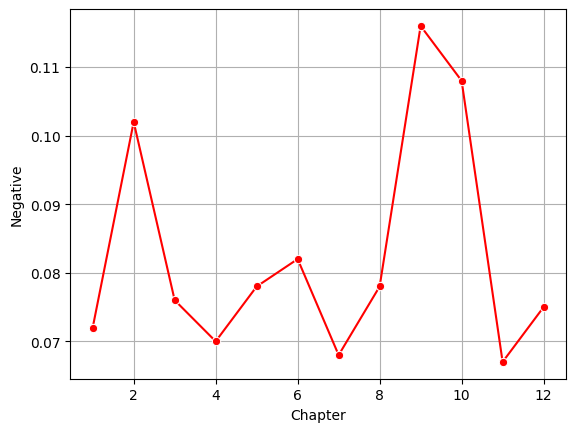

In [174]:
sns.lineplot(x='Chapter', y='Negative', marker='o', color='red', data=result_df)
plt.grid(True)

plt.show()

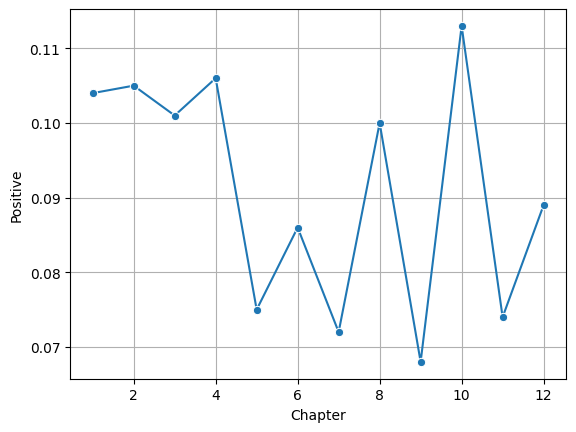

In [175]:
sns.lineplot(x='Chapter', y='Positive', marker='o', data=result_df)
plt.grid(True)

plt.show()

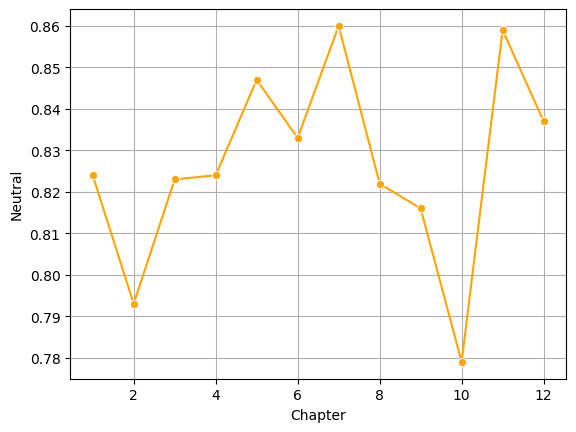

In [176]:
sns.lineplot(x='Chapter', y='Neutral', marker='o', color='orange', data=result_df)

plt.grid(True)
plt.show()

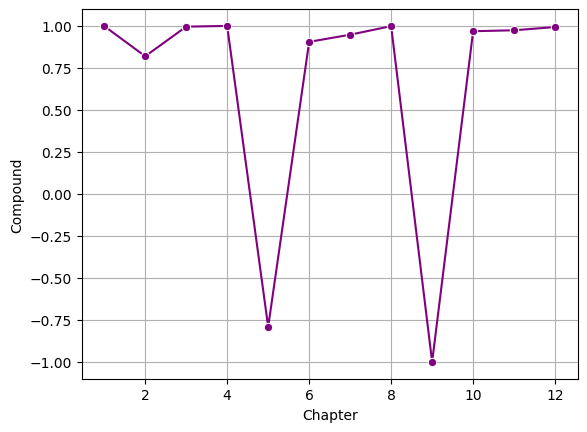

In [177]:
sns.lineplot(x='Chapter', y='Compound', marker='o', color='purple', data=result_df)

plt.grid(True)
plt.show()